In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import yaml

import wire_detection_utils as wdu

In [2]:
with open('wire_detect_config.yaml', 'r') as file:
    detection_config = yaml.safe_load(file)


line_threshold = detection_config['line_threshold']
pixel_binning_size = detection_config['pixel_binning_size']
low_canny_threshold = detection_config['low_canny_threshold']
high_canny_threshold = detection_config['high_canny_threshold']
bin_avg_threshold_multiplier = detection_config['bin_avg_threshold_multiplier']
value_threshold = detection_config['value_threshold']

input_image_size = [480, 270]

# Creat e a WireDetector instance
wire_detector = wdu.WireDetector(line_threshold, low_canny_threshold, high_canny_threshold, pixel_binning_size, bin_avg_threshold_multiplier)

# img = cv2.imread('input_imgs/outdoor_2.png')
img = cv2.imread('/media/tyler/Storage/field_tests/street_wire_experiments/wire_tracking_05-07_40fov/rgb_images/1746650652972994304.png')
# img = cv2.imread('/media/tyler/Storage/field_tests/acfa_3-21/rgb_images/1742581509450988704.png')
assert img is not None, "Image not found"

Wire detection Period: 0.002568 s, Frequency: 389.37 Hz


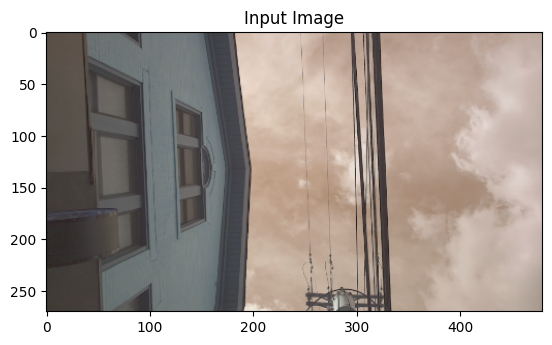

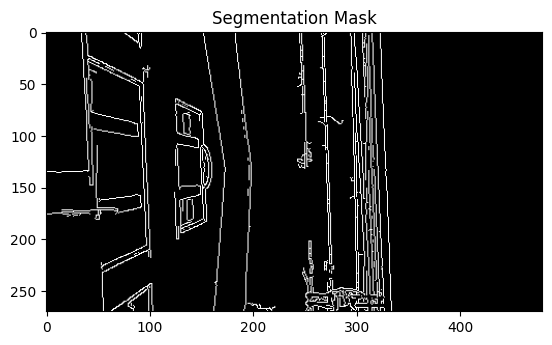

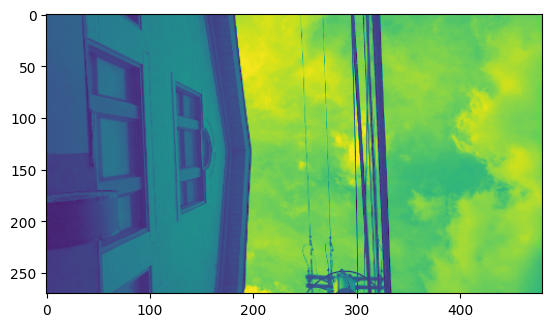

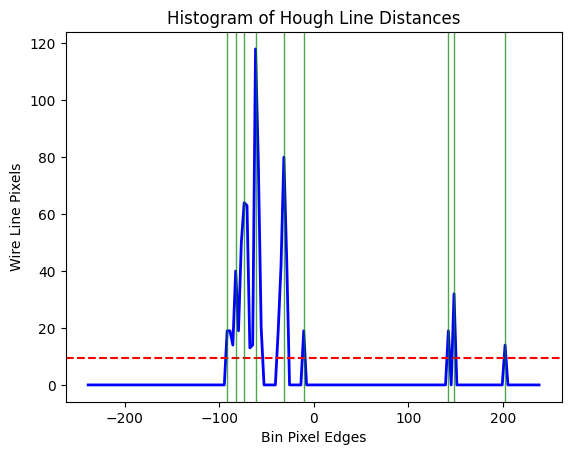

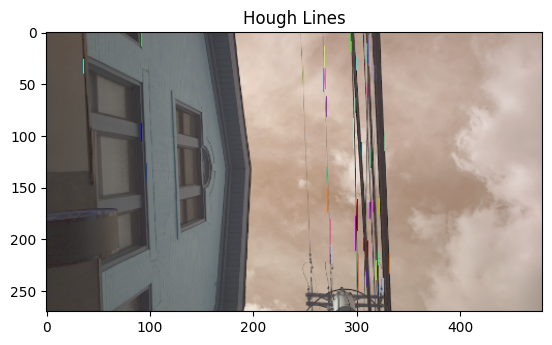

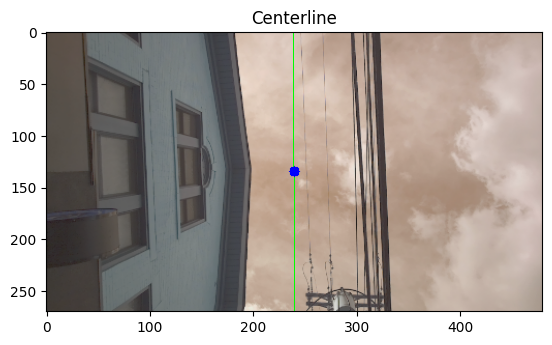

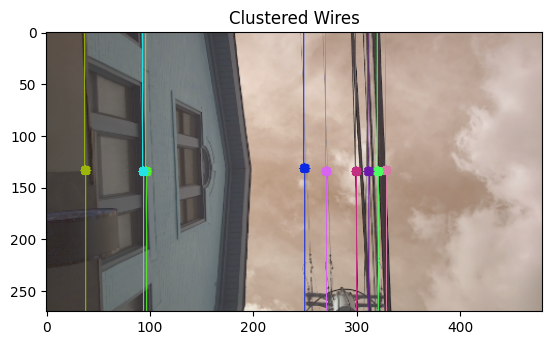

In [4]:
img = cv2.resize(img, (input_image_size[0], input_image_size[1]))
cv2.imwrite('detect_2d_output/reference.jpg', img)
plt.figure()
plt.title('Input Image')
plt.imshow(img)

# Create segmentation mask
seg_mask = wire_detector.create_seg_mask(img)
cv2.imwrite('detect_2d_output/seg_mask.jpg', seg_mask)
plt.figure()
plt.title('Segmentation Mask')
plt.imshow(seg_mask, cmap='gray')

# create value mask
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
cv2.imwrite('detect_2d_output/value_mask.jpg', v)
plt.figure()
plt.imshow(v)

# Detect wires using the segmentation mask
start_time = time.perf_counter()
cartesian_lines, line_lengths, center_line, avg_angle, seg_coords = wire_detector.get_hough_lines(seg_mask)
assert cartesian_lines is not None, "No lines found"

wire_lines, wire_midpoints, hist, bin_edges, bin_threshold, wire_distances_wrt_center = wire_detector.get_line_instance_locations(cartesian_lines, line_lengths, center_line, avg_angle, seg_coords)

end_time = time.perf_counter()
print(f"Wire detection Period: {end_time - start_time:.6f} s, Frequency: {1 / (end_time - start_time):.2f} Hz")
# Save the histogram and bin edges
plt.figure()
plt.plot(bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2, hist, color='b', linewidth=2)
plt.axhline(bin_threshold, color='r', linestyle='--')
for dist in wire_distances_wrt_center:
    plt.axvline(x=dist, color='g', linestyle='-', linewidth=1, alpha=0.7)
plt.title('Histogram of Hough Line Distances')
plt.xlabel('Bin Pixel Edges')
plt.ylabel('Wire Line Pixels')
plt.savefig('detect_2d_output/histogram.png')

# Visualize detected wires
hough_img = img.copy()
for x0, y0, x1, y1 in cartesian_lines:
    rand_color = tuple(np.random.randint(0, 256, 3).tolist())
    cv2.line(hough_img, (x0, y0), (x1, y1), rand_color, 1)
cv2.imwrite('detect_2d_output/hough_detect.jpg', hough_img)
plt.figure()
plt.title('Hough Lines')
plt.imshow(hough_img)

centerline_img = img.copy()
cv2.line(centerline_img, (center_line[0], center_line[1]), (center_line[2], center_line[3]), (0, 255, 0), 1)
cv2.circle(centerline_img, (int(wire_detector.cx), int(wire_detector.cy)), 5, (0, 0, 255), -1)
cv2.imwrite('detect_2d_output/centerline.jpg', centerline_img)
plt.figure()
plt.title('Centerline')
plt.imshow(centerline_img)

clustered_img = img.copy()
rand_colors = np.random.randint(0, 256, (len(wire_midpoints), 3)).tolist()
for i, (x0,y0,x1,y1) in enumerate(wire_lines):
    cv2.line(clustered_img, (x0,y0), (x1,y1), tuple(rand_colors[i]), 1)

for i, (x0,y0) in enumerate(wire_midpoints):
    cv2.circle(clustered_img, (int(x0), int(y0)), 5, tuple(rand_colors[i]), -1)

cv2.imwrite('detect_2d_output/cluster_detect.jpg', clustered_img)
plt.figure()
plt.title('Clustered Wires')
plt.imshow(clustered_img)
